<link rel="stylesheet" href="./styles.css">
<div class="warn">

<b>Custom CSS styling</b>

This notebook uses custom CSS styling. If you don't see this text on a colored background, make sure to not view it on GitHub, but instead in VSCode (or another editor that can render Jupyter notebooks with custom CSS). Note that the custom CSS also does not work in CoCalc due to a bug I've reported [here](https://github.com/sagemathinc/cocalc/issues/7560#issue-2302223105).
<br><br>

</div>

<link rel="stylesheet" href="./styles.css">
<div class="warn">

<b>⚠ This notebook is under construction</b>

This document is currently being worked on and is far from being complete / ready to use.<br>And don't worry, there will be more Sage-related code in the end.
<br><br>

</div>

# **Fourier Transform in SageMath**
**_A project by Felix Lentze & Dominic Plein ([@Splience](https://youtube.com/@splience))_**

In this project, we will discuss what sound is, how to represent it mathematically & in a computer, and how to examine its frequency content using the Fourier Transform. The latter will be implemented in SageMath, a free open-source computer algebra system as superset of Python which bundles many great libraries like numpy, scipy, matplotlib, and more. With the help of filter matrices, the frequency spectrum of a sound can be manipulated. This is demonstrated with some sample sounds.

This projected is intended for educational purposes, i.e. we don't focus on performance of our code (for that, see the FFT algorithm implemented in system-level languages like Rust or C++). Basic knowledge of linear algebra as well as Python are required. The key points are explained next to the code. The reader is encouraged to experiment with the code and the provided sound samples.

Throughout your journey of exploring the amazing world of Fourier in this notebook, you might want to have the amazing book [Linear algebra, signal proceessing, and wavelets. A unified approach.](https://www.uio.no/studier/emner/matnat/math/nedlagte-emner/MAT-INF2360/v15/kompendium/) by Øyvind Ryan open next to you. When we reference a theorem/definition from this book, we refer to the January 21, 2015 Python edition.

---

### **🌟 Preface: SageMath vs. Python?**

In the seminar, it might have come across as if Sage was a totally different programming language than Python. In fact, on the [SageMath website](https://www.sagemath.org/library-press.html), we find this:

> Leverages Existing Software: SageMath does not reinvent the wheel for every known calculation. When possible, it uses existing tools to solve the problem and combine all of them in one unique interface. This concept not only exposes software packages to a wider audience, but also helps to increase the quality by submitting bugs upstream.

> SageMath uses Python as its "glue language" to interface with all its components. Python is also SageMath's primary interface language and hence SageMath does not invent a new programming language as other mathematical software systems do. Python is well established among research communities and makes interfacing even less complicated.

So, SageMath uses Python as "glue language". In fact, it provides a unified Python interface to many great libraries in the scientific community, among other: `numpy`, `scipy`, `matplotlib`, `Maxima`, `BLAS` etc. (see also [here](https://doc.sagemath.org/html/en/faq/faq-general.html#why-did-you-write-sage-from-scratch-instead-of-using-other-existing-software-and-or-libraries)).

But then, you might wonder why you can write something like this:

```python
f(x) = x^2
```

This is not valid python syntax. You cannot name a variable f(x) in Python and to raise a number to a power, you use `**` instead of `^`. In SageMath, however, you can do this. This is because SageMath is a superset of Python, i.e. it extends the syntax of Python with some niceties like this one to make your life easier. Technically, Sage includes a [preparsing](https://doc.sagemath.org/html/en/developer/coding_in_python.html#sage-preparsing) step to convert the special syntax to valid Python code. If you want to dive deeper, [this is the Python method](https://github.com/sagemath/sage/blob/ffbbea9cb2360340f1c5517b590883fdaf02575c/src/sage/repl/preparse.py#L1382) responsible to parse statements like the one above.

In [1]:
# Only possible in Sage (but just syntactic sugar)
f(x) = x^2
print(f"Via SageMath syntax: {f(5)}")

# Sage will convert the above snippet to the following code internally.
# You can find this out by executing `preparse("f(x) = x^2")`.
__tmp__ = var("x");
f = symbolic_expression(x^Integer(2)).function(x)
print(f"Directly via Python (this is what SageMath does under the hood): {f(5)}")

Via SageMath syntax: 25
Directly via Python (this is what SageMath does under the hood): 25


**SageMath is a superset of Python. Therefore, every Python code you write is also SageMath code by definition (but not the other way around as seen in the example)**. Sage bundles many great open-source libraries and provides a unified interface to them.

### **🌟 Import packages**

From the [Sage documentation](https://doc.sagemath.org/html/en/thematic_tutorials/numerical_sage/numerical_tools.html): <small>(highlights & line breaks by us)</small>

> Sage has many different components that may be useful for numerical analysis. In particular three packages deserve mention, they are numpy, SciPy, and cvxopt.
> - **Numpy** is an excellent package that provides fast array facilities to python. It includes some basic linear algebra routines, vectorized math routines, random number generators, etc. It supports a programming style similar to one would use in matlab and most matlab techniques have an analogue in numpy.
> - **SciPy** builds on numpy and provides many different packages for optimization, root finding, statistics, linear algebra, interpolation, FFT and dsp tools, etc.

In [2]:
# Packages that ship with SageMath
# see https://doc.sagemath.org/html/en/reference/spkg/ for all packages
# that come distributed with Sage
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

# Interact with Jupyter notebooks, e.g. show sliders
# See https://doc.sagemath.org/html/en/reference/repl/sage/repl/ipython_kernel/interact.html
# from sage.repl.ipython_kernel.interact import interact

# Play audio samples in a Jupyter Notebook
from IPython.display import Audio

<hr>

### **🌟 Intro: What is sound \& some first experiments**

We hear sounds every day - the chirping of birds, the rustling of leaves, music, people talking. Physically speaking, sound is a pressure wave that propagates through a medium like air. Variations in air pressure near our ears cause our eardrums to vibrate. Through some more processes, these vibrations are converted into electrical signals that are sent to our brain, which interprets these signals as sound. The frequency (number of variations per seconds) of these pressure waves determines the pitch of the sound we hear. The amplitude of the pressure wave determines the loudness of the sound. As an example, consider the following sine wave and experiment with its parameters to see how they affect the sound:

$$
\boxed{
    A: \mathbb{R} \rightarrow \mathbb{R}, \quad
    t \mapsto A(t) \coloneqq A_0 \cdot \sin(2\pi f \cdot t + \varphi)
}
$$

$$
A_0: \text{Amplitude}, \quad
f: \text{Frequency}, \quad
\varphi: \text{Phase}
$$

**Watch out for your ears when playing the sound!**

In [3]:
# Don't worry about the sample rate yet, we'll cover what it is later
# when we talk about discrete signals.
SAMPLE_RATE = float(25000)  # sample rate (samples per second, Hz)
T_sound = 1  # duration of sound (seconds)

In [4]:
@interact
def sin_wave(f=slider(0, 1400, 1, default=440),
        phi=slider(0,2*pi), A_0=slider(0,1,0.1, default=0.8)):

    # Plot the sine wave (via SageMath)
    A(t) = A_0 * np.sin(2*pi*f*t + phi)
    show(plot(A(t), (t, 0, 0.06),
            color="red", thickness=1.5),
            xmin=0, xmax=0.06, ymin=-1, ymax=1,
            figsize=(10, 4), axes_labels=["t", "A(t)"])

    # Generate audio file
    t_linspace = np.linspace(0, T_sound, int(T_sound*SAMPLE_RATE), endpoint=False)
    wave = A_0 * np.sin(2*np.pi*f*t_linspace + phi)
    display(Audio(wave, rate=SAMPLE_RATE, normalize=False))

Interactive function <function sin_wave at 0x7f136e42e660> with 3 widgets
  f: TransformIntSlider(value=440, description='f', max=1400)
  phi: TransformFloatSlider(value=0.0, description='phi', max=6.283185307179586)
  A_0: TransformFloatSlider(value=0.8, description='A_0', max=1.0)

This sine wave describes the variations of air pressure, which forms the tone we hear. The bigger the frequency $f$, the higher the pitch. The bigger the amplitude $A_0$, the louder the sound.

It's therefore reasonable to say that we can model sounds by functions. A sound with frequency $f$ is modeled by a trigonometric function of that frequency. We call $\sin(2\pi f t)$ the **pure tone** of frequency $f$.

<link rel="stylesheet" href="./styles.css">
<div class="theorem">

<strong>Observation (Ryan, 1.1).
Sound as mathematical function.</strong>

A sound can be represented by a mathematical function, with time as the free variable.<br>When a *function* represents a sound, it is often referred to as a *continuous sound*.
<br><br>
</div>

#### **Summing up multiple sine waves**

An interesting idea might be to sum up multiple sine waves of different frequencies. We will sum them up pointwise, i.e. add up their respective values at each point in time. Let's experiment with two sine waves with the same amplitude, but different frequencies:

In [5]:
@interact
def add_up_two_sin_waves(
    f1=slider(400, 1000, 1, default=540),
    f2=slider(400, 1000, 1, default=548),
):
    def sound(t):
        return np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t)

    # Plot square wave
    t_for_plot = np.linspace(0, 0.04, 3000)
    y = sound(t_for_plot)

    plt.figure(figsize=(10, 4))
    plt.plot(t_for_plot, y, color="red", linewidth=1.5)
    plt.xlabel("t"); plt.ylabel("A(t)")

    # Generate audio file
    T_sound = 2
    t_for_audio = np.linspace(0, T_sound, int(T_sound * SAMPLE_RATE), endpoint=False)
    wave = sound(t_for_audio)
    display(Audio(wave, rate=SAMPLE_RATE))

Interactive function <function add_up_two_sin_waves at 0x7f13e8c5e840> with 2 widgets
  f1: TransformIntSlider(value=540, description='f1', max=1000, min=400)
  f2: TransformIntSlider(value=548, description='f2', max=1000, min=400)

A more complex example is the following one. This series approximates a square wave by adding up many individual sine waves (pure tones). It might seem quite surprising that we can indeed approximate a rectangular-looking wave by adding up "roundish" sine waves. We even add up discrete frequencies, but the sum of them approximates a continuous function. Listen to how the sound changes when we add more and more pure tones with higher frequencies.
$$
\begin{align*}
A(t) &\coloneqq \sum_{n=0}^{N}
\frac{4}{(2n+1)\pi} \sin\left(2\pi (2n+1) \frac{t}{T}\right)\\

&= \frac{4}{\pi} \sin\left(2\pi \cdot \frac{t}{T}\right)
+ \frac{4}{3\pi} \sin\left(2\pi \cdot 3 \frac{t}{T}\right)
+ \frac{4}{5\pi} \sin\left(2\pi \cdot 5\frac{t}{T}\right)
+ \frac{4}{7\pi} \sin\left(2\pi \cdot 7 \frac{t}{T}\right)
+ \cdots 
\end{align*}
$$

In [6]:
@interact
def square_wave(N=[2, 4, 6, 8, 10, 20, 40, 80, 180, 1000]):
    def sound(t):
        T = 0.5  # period of square wave: 2
        f = 300  # fixed frequency [Hz]
        y = np.zeros(np.shape(t))
        for n in range(1, N, 2):
            y = y + 4 / (n * np.pi) * np.sin(2 * np.pi * f * n * t / T)
        return y

    # Plot square wave
    t_for_plot = np.linspace(0, 0.005, 1000)
    y = sound(t_for_plot)

    plt.figure(figsize=(10, 4))
    plt.plot(t_for_plot, y, color="red", linewidth=1.5)
    plt.xlabel("t"); plt.ylabel("A(t)")

    # Generate audio file
    t_for_audio = np.linspace(0, T_sound, int(T_sound * SAMPLE_RATE), endpoint=False)
    wave = sound(t_for_audio)
    display(Audio(wave, rate=SAMPLE_RATE))

Interactive function <function square_wave at 0x7f136c77d940> with 1 widget
  N: Dropdown(description='N', options=(2, 4, 6, 8, 10, 20, 40, 80, 180, 1000), value=2)

Using another formula involving cosine functions, we can also approximate a triangle function. Compared to the square function it's a lot more pleasant to listen to; the sound is less "harsh". But not as "smooth" as for the pure sine wave.

$$
\begin{align*}
A(t) &\coloneqq \sum_{n=0}^{N}
\frac{8}{(2n+1)^2\pi^2} \cos\left(2\pi (2n+1) \frac{t}{T}\right)\\
&= - \frac{8}{\pi^2} \cos\left(2\pi \cdot \frac{t}{T}\right)
- \frac{8}{3^2\pi^2} \cos\left(2\pi \cdot 3 \frac{t}{T}\right)
- \frac{8}{5^2\pi^2} \cos\left(2\pi \cdot 5\frac{t}{T}\right)
- \frac{8}{7^2\pi^2} \cos\left(2\pi \cdot 7 \frac{t}{T}\right)
- \cdots
\end{align*}
$$

In [7]:
@interact
def triangle_wave(N=[2, 4, 6, 8, 10, 20, 40, 80, 180, 1000]):
    def sound(t):
        T = 0.5  # period of square wave: 2
        f = 440  # fixed frequency [Hz]
        y = np.zeros(np.shape(t))
        for n in range(1, N, 2):
            y = y + (-8) / (n**2 * np.pi**2) * np.cos(2 * np.pi * f * n * t / T)
        return y

    # Plot square wave
    t_for_plot = np.linspace(0, 0.005, 1000)
    y = sound(t_for_plot)

    plt.figure(figsize=(10, 4))
    plt.plot(t_for_plot, y, color="red", linewidth=1.5)
    plt.xlabel("t")
    plt.ylabel("A(t)")

    # Generate audio file
    t_for_audio = np.linspace(0, T_sound, int(T_sound * SAMPLE_RATE), endpoint=False)
    wave = sound(t_for_audio)
    display(Audio(wave, rate=SAMPLE_RATE))

Interactive function <function triangle_wave at 0x7f13633f8220> with 1 widget
  N: Dropdown(description='N', options=(2, 4, 6, 8, 10, 20, 40, 80, 180, 1000), value=2)

At this point, we might ask ourselves, whether we can construct any arbitrary sound by summing up pure tones (sine & cosine waves). Our observation or rather our hope is that we can *de*compose any arbitrary sound into a sum of pure tones. This would give us a powerful tool to analyze and manipulate sounds as we could directly work with the different frequencies represented in a sound.

<link rel="stylesheet" href="./styles.css">
<div class="theorem">

<strong>A first hope (Ryan, 1.8).
Decomposition of sound into pure tones.</strong>

Any sound $f$ is a sum of pure tones at different frequencies. The amount of each frequency required to form $f$ is the *frequency content* of $f$. Any sound can be reconstructed from its frequency content.
<br><br>
</div>

---

### **🌟 Fourier series**

We've seen that we can identify a sound with a function. Now, we will make our first hope more precise. Enter the **Fourier analysis**, which allows us to model sound as a sum of frequency components. That is, we want to **approximate functions with the help up trigonometric functions**.

#### **Periodicity**

For the sake of simplicity, we will only consider periodic functions through this document.

<link rel="stylesheet" href="./styles.css">
<div class="def">

<strong>Definition (Ryan, 1.5).
Periodic functions.</strong>

A function $f: \mathbb{R} \to \mathbb{C}$ is *periodic* with period $T\neq0$ if
$$
f(t) = f(t+T) \quad \forall t \in \mathbb{R}
$$
<br>
</div>

In other words: if we know $f$ for a single period, we know it for all times. This is a very strong property that will be exploited constantly in the following. Real-world sounds are aperiodic most of the time. However, we can think of such an aperiodic signal "as the limit of a periodic signal as the period becomes arbitrarily large" ~ [Alan V. Oppenheim et al. Signals and Systems, 2nd edition, p. 286](https://math.stackexchange.com/a/4851674/1083321). Don't worry about this too much, just accept we will only work with periodic functions for now. Let's dive into the theory.

#### **Continuous functions \& inner product**

Our goal is to approximate a periodic function $f: [0,T] \to \mathbb{C}$ by a linear combination of the trigonometric functions $\sin$ and $\cos$. The first question is: **How general do we allow $f$ to be?** We will demand our function $f$ to be continuous.

<link rel="stylesheet" href="./styles.css">
<div class="def">

<strong>Definition (Ryan, 1.13).
Continuous functions.</strong>

The set of continuous functions defined on an interval $[0,T]$ is denoted $C[0,T]$.

<!-- The function $f: [0,T] \to \mathbb{R}$ is said to be **square integrable** on $[0,T]$ if $f^2$ is Riemann-integrable,
<br>i.e., if the Riemann integral of $f^2$ on $[0,T]$ exists:

$$
\int_0^T \bigl|f(t)\bigr|^2 \, \text{d}t < \infty
$$

The set of all square integrable functions on $[0,T]$ is denoted $L^2[0,T]$. -->

<br>
</div>

In theory, we don't need the strong assumption $f \in C[0,T]$. Instead, $f\in L^2[0,T]$ (i.e. $f$ is square-integrable) would be sufficient. However, in practice, we will often work with continuous functions and for the sake of this seminar and to simplify the discussion, we will assume that $f \in C[0,T]$.

We can also define an inner product for the vector space $C[0,T]$:

<!-- So when we write $f\in L^2[0,T]$, we mean that $f$ is square integrable on the interval $[0,T]$. This is a very important property for the functions we will work with. It ensures that the functions we work with are "well-behaved" in some sense. We can also define an inner product on $L^2[0,T]$: -->

<link rel="stylesheet" href="./styles.css">
<div class="def">

<strong>Definition (Ryan, 1.14).
Inner product.</strong>

<!-- Both $L^2[0,T]$ and $C[0,T]$ are vector spaces.
<br>If the two functions $f$ and $g$ lie in $L^2[0,T]$ (or in $C[0,T]$), then the product $fg$ is also in $L^2[0,T]$ (or in $C[0,T]$). -->

<!-- Moreover, both spaces are inner product spaces, with inner product defined by -->

The inner product for $C[0,T]$ is defined by:

$$
\langle f,g \rangle \coloneqq \frac{1}{T} \int_0^T f(t) \overline{g(t)} \, \text{d}t
$$
The associated norm is then given by:
$$
\|f \| \coloneqq \sqrt{\langle f,f \rangle} = \sqrt{\frac{1}{T} \int_0^T \bigl|f(t)\bigr|^2 \, \text{d}t}
$$

<br>
</div>

Here, $\overline{g(t)}$ is the complex conjugate of $g(t)$. The normalizing factor $\frac{1}{T}$ is just needed to ensure the constant function $f(t) = 1$ has norm $1$.

#### **Basis \& linear combination**

So you might ask why we need the inner product. It plays a crucial role in the following. First, we define a basis $\mathscr{F}_{N,T}$ for a subspace $V_{N,T} \subset C[0,T]$ that is spanned by $2N+1$ pure tone functions.

<link rel="stylesheet" href="./styles.css">
<div class="def">

<strong>Definition (Ryan, 1.15/1.22).
Complex fourier basis.</strong>

- We define the following set functions and call it the **Nth order complex Fourier basis** for $V_{N,T}$:

$$
\mathscr{F}_{N,T} \coloneqq \{ 
    e^{-2\pi i \frac{N t}{T}},
    e^{-2\pi i \frac{(N-1) t}{T}},
    \cdots,
    e^{-2\pi i \frac{t}{T}},
    1,
    e^{2\pi i \frac{t}{T}},
    \cdots,
    e^{2\pi i \frac{(N-1) t}{T}},
    e^{2\pi i \frac{N t}{T}}
\}
$$

- $V_{N,T}$ is defined as the subspace of $C[0,T]$ spanned by the set of functions $\mathscr{F}_{N,T}$.<br>$V_{N,T}$ is called the **Nth-order Fourier space**.

- $f_N$ is defined as the best approximation of $f$ from $V_{N,T}$ with respect to the inner product defined above.<br>$f_N$ is called the **Nth-order Fourier series approximation of $f$**.

<br>
</div>

- It's not difficult to see that the functions $e^{2\pi i \frac{nt}{T}}$ are orthonormal with respect to the inner product defined above.
- $f_N$ is defined as the best approximation of $f$ from $V_{N,T}$ with respect to the inner product defined above.<br>What's a best approximation? Let's consult linear algebra:

<link rel="stylesheet" href="./styles.css">
<div class="theorem">

<strong>Theorem (Lay et al. Orthogonality \& Least Squares, Theorem 9).
Best approximation theorem.</strong>

Let $W \subseteq \mathbb{R}^n$, let $y \in \mathbb{R}^n$, and let $\hat{y}$ be the orthogonal projection of $y$ onto $W$.
<br>Then $\hat{y}$ is the closest point in $W$ to $y$, in the sense that

$$
\| y - \hat{y} \| < \| y - v \| \text{ for all } v \in W \text{ distinct from } \hat{y}
$$

<br>
</div>

In our case, we don't consider $\mathbb{R}^n$, but instead $C[0,T]$ with our norm associated to the inner product defined above.

Since $f_N$ lives in $V_{N,T}$ (which is spanned by the basis $\mathscr{F}_{N,T}$ of pure tones), we can write $f_N$ as a linear combination of the basis functions (per definition of a basis):

$$
f_N(t) = \sum_{n=-N}^{N} z_n \cdot e^{2\pi i \frac{n t}{T}}
$$

The $e^{2\pi i \frac{n t}{T}}$ are the basis functions (pure tones) and the $z_n$ are the coefficients of the linear combination.<br>Let's visualize the current situation:

![Fourier series](../images/orthogonal%20decomposition.png)

The question is now: **How to calculate the coefficients $z_n$?** The following theorem gives an answer:

<link rel="stylesheet" href="./styles.css">
<div class="theorem">

<strong>Theorem (Ryan, 1.16/1.23).
Fourier series coefficients.</strong>

The set $\mathscr{F}_{N,T}$ is an orthonormal basis for $V_{N,T}$. In particular, the dimension of $V_{N,T}$ is $2N+1$.
<br>We denote by $z_{-N}, \cdots, z_0, \cdots, z_N$ the coordinates of $f_N$ in the basis $\mathscr{F}_{N,T}$, i.e.

$$
f_N(t) = \sum_{n=-N}^{N} z_n \cdot e^{2\pi i \frac{n t}{T}}
$$

The $z_n$ are called the complex Fourier coefficients of $f$, and they are given by:

$$
z_n = \langle f, e^{2\pi i \frac{n t}{T}} \rangle
= \frac{1}{T} \int_0^T f(t) \cdot e^{-2\pi i \frac{n t}{T}} \, \text{d}t
$$

<br>
</div>

So where does the formula for the complex numbers $z_n$ come from? Well, that's the orthogonal decomposition theorem in action:

<link rel="stylesheet" href="./styles.css">
<div class="theorem">

<strong>Theorem (Lay et al. Orthogonality \& Least Squares, Theorem 9).
The Orthogonal Decomposition Theorem.</strong>

Let $W$ be a subspace of $\mathbb{R}^n$. Then each $y \in \mathbb{R}^n$ can be written uniquely in the form
$$
y = \hat{y} + p \quad \text{ where } \hat{y} \in W \text{ and } p\in W^\perp
$$
In fact, if $\{u_1, \cdots, u_p\}$ is any orthogonal basis of $W$, then:
$$
\hat{y} = \frac{y\cdot u_1}{u_1 \cdot u_1} u_1 + \cdots
+ \frac{y\cdot u_p}{u_p \cdot u_p} u_p
$$
and $p = y - \hat{y}$.

<br>
</div>

You might be familiar with this in the context of the Gram-Schmidt process. Here again, we don't consider the space $\mathbb{R}^n$, but instead $C[0,T]$. In our case, $W$ is the subspace $V_{N,T}$ spanned by the basis $\mathscr{F}_{N,T}$ of pure tones. The orthogonal projection $\hat{y}$ of $f$ onto $V_{N,T}$ is the best approximation $f_N$ of $f$ from $V_{N,T}$. Instead of the dot product in $\mathbb{R}^n$, we use the inner product defined above. For $u_i$ we use our pure tone basis functions $e^{2\pi i n t / T}$. Making use of $\langle e^{2\pi i n t / T}, e^{2\pi i n t / T} \rangle = 1$ (orthonormal), we obtain:

$$
\begin{align*}
f_N(t) &= \sum_{n=-N}^{N} \frac{\langle f, e^{2\pi i n t / T}\rangle}
{\langle e^{2\pi i n t / T}, e^{2\pi i n t / T} \rangle} e^{2\pi i n t / T}
= \sum_{n=-N}^{N} \langle f, e^{2\pi i n t / T}\rangle e^{2\pi i n t / T}\\
&= \sum_{n=-N}^{N}
\underbrace{\left( \frac{1}{T} \int_0^T f(t) e^{-2\pi i n t / T}\right)}_{\eqqcolon z_n}
e^{2\pi i n t / T}
\end{align*}
$$

This is the formula for the Fourier series coefficients $z_n$.

#### **Convergence**

It's not trivial to find conditions for $f$ that guarantee the convergence of its Fourier series. We won't go into detail here. Instead, it's sufficient for us to know that when we choose $N$ large enough, "any reasonable periodic function can be approximated arbitrarily well by its Nth-order Fourier series approximation" ~ [Ryan, p. 15]. That is, we will assume the following to be true for the rest of this document (it's not true in general, but good enough for our choice of functions):

$$
\lim_{N\to \infty} f_N(t) = f(t) \quad \forall t\in \mathbb{R}
$$

#### **Solve integral with SageMath**

**TODO**

In [36]:
var("t")
f = 440  # frequency [Hz]
T = 1/f
# square wave: 1 for 0<=t<T/2, -1 for T/2<=t<T (and repeat every T)
square_wave(t) = sgn(sin(2 * pi * t / T))


def frequency_content(n):
    pure_tone(t) = e^(-2 * pi * i * n * t / T)
    to_integrate = square_wave(t) * pure_tone(t)
    return 1/T * to_integrate.integral(t, a=0, b=T)


@interact
def show_frequency_content(n=slider(-20, 20, 1, default=1)):
    amount = frequency_content(n)
    magnitude = abs(amount)
    print(f"💫 How much is frequency {abs(n)}*{f}Hz = {n*f}Hz represented in signal: {magnitude}")

Interactive function <function show_frequency_content at 0x7f13588f87c0> with 1 widget
  n: TransformIntSlider(value=1, description='n', max=20, min=-20)

Discontinuities at zeroes of sin(pi*sageVARt*880) were not checked


From Euler's formula, we know that $e^{ix} = \cos(x) + i\sin(x)$.
<br>With this, it follows that the $\sin$ can be expressed in terms of the exponential function:
$$
\sin(t) = \frac{1}{2i}\left(e^{it} - e^{-it}\right)
$$

**TODO: Why different with factor 2?**

This is exactly how we found the coefficients above for the square wave and the triangle wave. For the square wave, we get:
$$
\begin{align*}
A(t) &\coloneqq \sum_{n=0}^{N}
\frac{4}{(2n+1)\pi} \sin\left(2\pi (2n+1) \frac{t}{T}\right)\\
&= \frac{4}{\pi} \sin\left(2\pi \cdot \frac{t}{T}\right)
+ \frac{4}{3\pi} \sin\left(2\pi \cdot 3 \frac{t}{T}\right)
+ \frac{4}{5\pi} \sin\left(2\pi \cdot 5\frac{t}{T}\right)
+ \frac{4}{7\pi} \sin\left(2\pi \cdot 7 \frac{t}{T}\right)
+ \cdots\\
&= \frac{2}{\pi} \left|e^{2\pi i \frac{t}{T}} - e^{-2\pi i \frac{t}{T}}\right|
+ \frac{2}{3\pi} \left|e^{2\pi i \cdot 3 \frac{t}{T}} - e^{-2\pi i \cdot 3 \frac{t}{T}}\right|
+ \frac{2}{5\pi} \left|e^{2\pi i \cdot 5 \frac{t}{T}} - e^{-2\pi i \cdot 5 \frac{t}{T}}\right|
+ \frac{2}{7\pi} \left|e^{2\pi i \cdot 7 \frac{t}{T}} - e^{-2\pi i \cdot 7 \frac{t}{T}}\right|
+ \cdots
\end{align*}
$$

**Frequency diagram**

In [55]:
N = 20
frequencies = range(-N, N + 1)
amplitudes = [float(abs(frequency_content(n))) if n != 0 else float(0.0) for n in frequencies]

Warning, integration of abs or sign assumes constant sign by intervals (correct if the argument is real):
Check [sign(sin(pi*sageVARt*880))]
Discontinuities at zeroes of sin(pi*sageVARt*880) were not checked
Warning, integration of abs or sign assumes constant sign by intervals (correct if the argument is real):
Check [sign(sin(pi*sageVARt*880))]
Discontinuities at zeroes of sin(pi*sageVARt*880) were not checked
Warning, integration of abs or sign assumes constant sign by intervals (correct if the argument is real):
Check [sign(sin(pi*sageVARt*880))]
Discontinuities at zeroes of sin(pi*sageVARt*880) were not checked
Warning, integration of abs or sign assumes constant sign by intervals (correct if the argument is real):
Check [sign(sin(pi*sageVARt*880))]
Discontinuities at zeroes of sin(pi*sageVARt*880) were not checked
Warning, integration of abs or sign assumes constant sign by intervals (correct if the argument is real):
Check [sign(sin(pi*sageVARt*880))]
Discontinuities at zeroes o

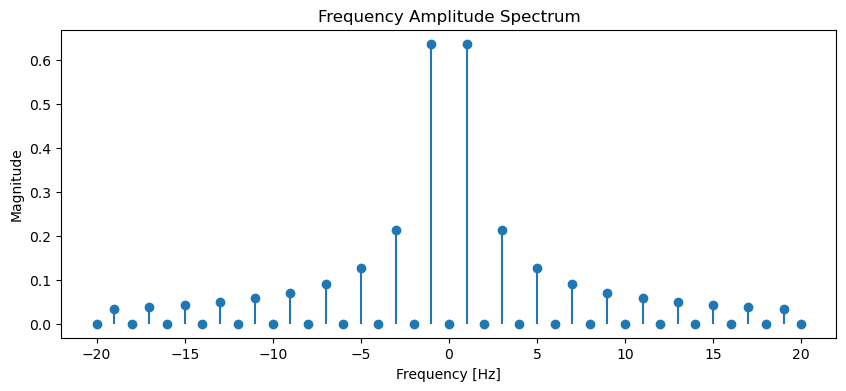

In [56]:
# Plot the frequency amplitude spectrum (discrete)
plt.figure(figsize=(10, 4))
plt.stem(frequencies, amplitudes, basefmt=" ")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Frequency Amplitude Spectrum")
plt.show()

---

### **🌟 Discrete Fourier Transform (DFT)**

TODO

---

---

---

<hr>

**TODO: Work more intensely on the following sections.**

<hr>

---

---

---

> Fourier series represent signals by their frequency content. 

> If the function was periodic we
could define its Fourier series, which can be thought of as an approximation scheme
for periodic functions using finite-dimensional spaces of trigonometric functions.

> we also defined analog filters, which were operations which operate on continuous sound, without any assumption on periodicity. 

**Aperiodic signals & Fourier transform vs. Fourier series**

We can "think of an aperiodic signal as the limit of a periodic signal as the period becomes arbitrarily large [...]"
~ [Alan V. Oppenheim et al. Signals and Systems, 2nd edition, p. 286](https://math.stackexchange.com/a/4851674/1083321)

We "represent a signal as linear combination of complex exponentials". For periodic signals, these complex exponentials [...] occur at a discrete set of harmonically related frequencies [...]. For aperiodic signals, the complex exponentials occur at a continuous at a continuum of frequencies.
~ [Alan V. Oppenheim et al. Signals and Systems, 2nd edition, p. 286](https://math.stackexchange.com/a/4851674/1083321)

> It can be shown that the Fourier series coefficients of a periodic function are sampled values of the Fourier transform of one period of the function. ~ [Stack Overflow](https://math.stackexchange.com/a/221253/1083321)

> The focus in Discrete Fourier analysis is to change coordinates from standard basis to the Fourier basis, performing some operations on this "Fourier representation", and then change coordinates back to the standard basis. [Ryan, p. 51]

### **Discrete Fourier Transform (DFT)**

Importing important libarys and implementing DFT function 

In [ ]:
def dft(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)

    X = np.dot(e, x)

    return X

Importing .wav-file and printing length of the vector and sample rate

Vector containing air pressure differences at different (discrete) time steps
Sample rate says how many samples per second the .wav-file contains (normally 44100)

In [ ]:
sample_rate, wav_data = wavfile.read("../data/sounds/sin02.wav")
print(len(wav_data))
print(wav_data)
print(sample_rate)

### **Fourier transformation**

performing DFT on wav-Vector. 
dft_result contains "frequencies" ( = periodic functions with given frequency) and quantity of frequence in measured signal

In [ ]:
dft_result = np.fft.fft(wav_data)
print(dft_result)
n = len(dft_result)
n

Determine occuring frequencies

In [ ]:
n = len(wav_data)
print(n)
freqs = np.fft.fftfreq(n)
print(freqs)

### **Plot**

Creating plot with amplitude of frequencies

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.real(dft_result))  # Nur die positive Frequenzhälfte
plt.title("Fouriertransformierte des WAV-Vektors")
plt.xlabel("Frequenz (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

### **Inverse Discrete Fourier Transform (IDFT)**


In [ ]:
def idft(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(2j * np.pi * k * n / N)

    X = np.dot(e, x)

    return (1/N)*X

In [ ]:
idft_result = idft(dft_result)
len(idft_result)
idft_result

### **Fix rounding issues**

In [ ]:
idft_rounded = np.around(idft_result, 6)  # 6 -> ok, 7 -> not ok

if np.array_equal(wav_data, idft_rounded):
    print("ok")
else:
    print("not ok")

### **`.wav` output**

In [ ]:
wavfile.write("../data/sounds/output.wav", 44100, idft_rounded)